In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

Using TensorFlow backend.


using Keras version: 2.2.4


# Building a Chinese-Language Sentiment Analyzer

In this notebook, we will build a Chinese-language text classification model in 4 simple steps. More specifically, we will build a model that classifies Chinese hotel reviews as either positive or negative.

The dataset can be downloaded from Chengwei Zhang's GitHub repository [here](https://github.com/Tony607/Chinese_sentiment_analysis/tree/master/data/ChnSentiCorp_htl_ba_6000).

(**Disclaimer:** I don't speak Chinese. Please forgive mistakes.)  

## STEP 1:  Load and Preprocess the Data

First, we use the `texts_from_folder` function to load and preprocess the data.  We assume that the data is in the following form:
```
    ├── datadir
    │   ├── train
    │   │   ├── class0       # folder containing documents of class 0
    │   │   ├── class1       # folder containing documents of class 1
    │   │   ├── class2       # folder containing documents of class 2
    │   │   └── classN       # folder containing documents of class N
```
We set `val_pct` as 0.1, which will automatically sample 10% of the data for validation.  We specifiy `preprocess_mode='standard'` to employ normal text preprocessing.  If you are using the BERT model (i.e., 'bert'), you should use `preprocess_mode='bert'`.

**Notice that there is nothing speical or extra we need to do here for non-English text.**  *ktrain* automatically detects the language and character encoding and prepares the data and configures the model appropriately.



In [3]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder('data/ChnSentiCorp_htl_ba_6000', 
                                                                       maxlen=75, 
                                                                       max_features=30000,
                                                                       preprocess_mode='standard',
                                                                       train_test_names=['train'],
                                                                       val_pct=0.1,
                                                                       classes=['pos', 'neg'])

detected encoding: GB18030
Decoding with GB18030 failed 1st attempt - using GB18030 with skips
skipped 104 lines (0.3%) due to character decoding errors
skipped 14 lines (0.4%) due to character decoding errors


Building prefix dict from the default dictionary ...
I1001 15:11:00.816586 140470484846400 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
I1001 15:11:00.818966 140470484846400 __init__.py:131] Loading model from cache /tmp/jieba.cache


language: zh-cn


Loading model cost 0.641 seconds.
I1001 15:11:01.459813 140470484846400 __init__.py:163] Loading model cost 0.641 seconds.
Prefix dict has been built succesfully.
I1001 15:11:01.461843 140470484846400 __init__.py:164] Prefix dict has been built succesfully.


Word Counts: 22066
Nrows: 5324
5324 train sequences
Average train sequence length: 81
x_train shape: (5324,75)
y_train shape: (5324,2)
592 test sequences
Average test sequence length: 85
x_test shape: (592,75)
y_test shape: (592,2)


## STEP 2:  Create a Model and Wrap in Learner Object

In [4]:
model = text.text_classifier('fasttext', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

Is Multi-Label? False
compiling word ID features...
maxlen is 75
done.


## STEP 3: Estimate the LR
We'll use the *ktrain* learning rate finder to find a good learning rate to use with *fasttext*. We select a high learning rate that is associated with a still falling loss from the plot.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
5324/5324 [==============================] - 2s 466us/step - loss: 0.9928 - acc: 0.5173
Epoch 2/1024
5324/5324 [==============================] - 2s 308us/step - loss: 1.0088 - acc: 0.5011
Epoch 3/1024
5324/5324 [==============================] - 2s 324us/step - loss: 0.9870 - acc: 0.5066
Epoch 4/1024
5324/5324 [==============================] - 2s 314us/step - loss: 0.9727 - acc: 0.5116
Epoch 5/1024
5324/5324 [==============================] - 2s 319us/step - loss: 0.8829 - acc: 0.5406
Epoch 6/1024
5324/5324 [==============================] - 2s 309us/step - loss: 0.6585 - acc: 0.6597
Epoch 7/1024
5324/5324 [==============================] - 2s 314us/step - loss: 0.5113 - acc: 0.7607
Epoch 8/1024
5324/5324 [==============================] - 2s 309us/step - loss: 0.4962 - acc: 0.7746
Epoch 9/1024
5324/5324 [==============================] - 2s 318us/step - loss: 0.6645 - acc: 0.5920
Epoch 10

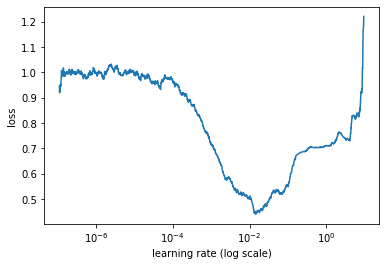

In [5]:
learner.lr_find(show_plot=True)

## STEP 4: Train the Model

We will use the `fit_onecycle` method that employs a [1cycle learning rate policy](https://arxiv.org/pdf/1803.09820.pdf) for 10 epochs (i.e., roughly 20 seconds).

In [10]:
learner.fit_onecycle(5e-3, 10)



begin training using onecycle policy with max lr of 0.005...
Train on 5324 samples, validate on 592 samples
Epoch 1/10
5324/5324 [==============================] - 2s 356us/step - loss: 0.7315 - acc: 0.6409 - val_loss: 0.4885 - val_acc: 0.7669
Epoch 2/10
5324/5324 [==============================] - 2s 352us/step - loss: 0.4666 - acc: 0.7855 - val_loss: 0.3647 - val_acc: 0.8530
Epoch 3/10
5324/5324 [==============================] - 2s 353us/step - loss: 0.3553 - acc: 0.8492 - val_loss: 0.3181 - val_acc: 0.8750
Epoch 4/10
5324/5324 [==============================] - 2s 356us/step - loss: 0.2746 - acc: 0.8875 - val_loss: 0.3126 - val_acc: 0.8699
Epoch 5/10
5324/5324 [==============================] - 2s 349us/step - loss: 0.2424 - acc: 0.9031 - val_loss: 0.3129 - val_acc: 0.8801
Epoch 6/10
5324/5324 [==============================] - 2s 353us/step - loss: 0.2130 - acc: 0.9174 - val_loss: 0.2984 - val_acc: 0.8750
Epoch 7/10
5324/5324 [==============================] - 2s 352us/step - lo

In [11]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

         neg       0.91      0.91      0.91       315
         pos       0.90      0.89      0.90       277

    accuracy                           0.90       592
   macro avg       0.90      0.90      0.90       592
weighted avg       0.90      0.90      0.90       592



array([[288,  27],
       [ 30, 247]])

### Inspecting Misclassifications

In [12]:
learner.view_top_losses(n=1, preproc=preproc)

----------
id:345 | loss:10.15 | true:pos | pred:neg)

所谓山景房，就是非海景房而已，没有什么山景可言，海景房确实，有条件尽量选。只是这种房的窗帘边上拉不严，早上光线进来如同亮着灯一般，可能引发。另外窗外隔音不佳，如果呼呼明显，这想必也必不了了。


Using Google Translate, the above roughly translates to:
```

The so-called mountain view room is just a non-sea view room, there is no mountain view at all, the sea view room is indeed, there are conditions to choose as much as possible. It’s just that the curtains in this room are not pulled up. The morning light comes in like a lit lamp, which may be triggered. In addition, the sound insulation outside the window is not good. If the whirring is obvious, it must be no longer necessary.
```

Mistranslations aside, this is clearly a negative review.  It appears to have been incorrectly assigned a ground-truth label of positive.

### Making Predictions on New Data

In [13]:
p = ktrain.get_predictor(learner.model, preproc)

Predicting label for the text
> "*The view and service of this hotel were terrible and our room was dirty.*"

In [16]:
p.predict("这家酒店的看法和服务都很糟糕，我们的房间很脏。")

'neg'

Predicting label for:
> "*I like the service of this hotel.*"

In [17]:
p.predict('我喜欢这家酒店的服务')

'pos'

### Saving Predictor for Later Deployment

In [18]:
p.save('/tmp/mypred')

In [19]:
p = ktrain.load_predictor('/tmp/mypred')

In [20]:
# still works
p.predict("这家酒店的风景和服务都非常糟糕")

'neg'